# 🚀 Advanced LLM Integration with LangChain and Gradio

Welcome to this advanced notebook on integrating Large Language Models (LLMs) with LangChain and Gradio! In this tutorial, we'll explore how to create a sophisticated chatbot that can scrape Wikipedia, use vector stores for information retrieval, and provide a user-friendly interface.

## 🚀 What we'll cover:

1. Setting up a custom LLM
2. Creating a conversation chain with memory
3. Implementing Wikipedia scraping and information extraction
4. Using FAISS for vector storage and retrieval
5. Building a Gradio interface for user interaction

Let's get started! 🚀

## 1️⃣ Setting up the Environment

First, let's import the necessary libraries and set up logging.

In [1]:
import gradio as gr
from langchain.llms.base import LLM
from langchain.callbacks.manager import CallbackManagerForLLMRun
from langchain.memory import ConversationBufferWindowMemory
from langchain.chains import ConversationChain
from langchain_community.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.docstore.document import Document
import requests
import json
import logging
import re
from urllib.parse import urlparse
from bs4 import BeautifulSoup

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

USER_AGENT environment variable not set, consider setting it to identify your requests.


## 2️⃣ Creating a Custom LLM

Now, let's create a custom LLM class that interacts with an API.

In [2]:
class CustomLLM(LLM):
    api_url: str = "http://127.0.0.1:8899/v1/completions"

    def _call(
        self,
        prompt,
        stop = None,
        run_manager = None,
    ):
        headers = {
            "Content-Type": "application/json"
        }
        data = {
            "prompt": prompt + "\nAnswer:",
            "max_tokens": 250,
            "temperature": 0.7,
            "top_p": 1.0,
            "n": 1,
            "stop": stop or ["Human:", "\n\n"]
        }
        try:
            logger.info(f"Sending prompt to API: {prompt}")
            response = requests.post(self.api_url, headers=headers, data=json.dumps(data))
            response.raise_for_status()
            result = response.json()['choices'][0]['text']
            logger.info(f"Received response from API: {result}")
            return result.strip()
        except requests.exceptions.RequestException as e:
            logger.error(f"API request failed: {str(e)}")
            return f"Sorry, I encountered an error: {str(e)}"

    @property
    def _llm_type(self):
        return "custom"

# Initialize the custom LLM
llm = CustomLLM()

## 3️⃣ Setting up Conversation Chain and Vector Store

Let's set up a conversation chain with memory and initialize our vector store.



In [3]:
# Initialize the conversation chain with a window memory
conversation = ConversationChain(
    llm=llm,
    memory=ConversationBufferWindowMemory(k=3, return_messages=True)
)

# Initialize embeddings
embeddings = HuggingFaceEmbeddings(model_kwargs={"device": 1})

# Initialize FAISS vector store
vector_store = None

/tmp/ipykernel_2165284/2729524625.py:2: LangChainDeprecationWarning: The class `ConversationChain` was deprecated in LangChain 0.2.7 and will be removed in 1.0. Use RunnableWithMessageHistory: https://python.langchain.com/v0.2/api_reference/core/runnables/langchain_core.runnables.history.RunnableWithMessageHistory.html instead.
  conversation = ConversationChain(
/tmp/ipykernel_2165284/2729524625.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the langchain-huggingface package and should be used instead. To use it run `pip install -U langchain-huggingface` and import as `from langchain_huggingface import HuggingFaceEmbeddings`.
  embeddings = HuggingFaceEmbeddings()
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: sentence-transformers/all-mpnet-base-v2

## 4️⃣ Implementing Wikipedia Scraping and Information Extraction

Now, let's create functions to scrape Wikipedia and extract information.

In [4]:
def simple_extract(content):
    prompt = f"""
    Summarize the following Wikipedia content in a few sentences:

    {content[:1000]}  # Limited to 1000 characters

    Summary:
    """
    
    response = llm(prompt)
    logger.info(f"Extraction response: {response}")
    return response

def scrape_wikipedia(url):
    global vector_store
    try:
        # Validate URL
        result = urlparse(url)
        if not all([result.scheme, result.netloc]) or "wikipedia.org" not in result.netloc:
            return "Invalid URL. Please provide a complete Wikipedia URL."

        # Load web content
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the main content div
        content_div = soup.find('div', {'id': 'mw-content-text'})

        # Extract title
        title = soup.find('h1', {'id': 'firstHeading'}).text

        # Extract content
        content = []
        if content_div:
            for elem in content_div.find_all(['p', 'h2', 'h3']):
                if elem.name == 'p':
                    content.append(elem.text)
                elif elem.name in ['h2', 'h3']:
                    content.append(f"\n\n{elem.text}\n")

        full_content = f"{title}\n\n{''.join(content)}"
        logger.info(f"Scraped content (first 1000 chars): {full_content[:1000]}")

        # Extract content with simple function
        extracted_content = simple_extract(full_content)
        logger.info(f"Extracted content: {extracted_content}")

        # Create or update the vector store
        if vector_store is None:
            vector_store = FAISS.from_texts([extracted_content], embeddings)
        else:
            vector_store.add_texts([extracted_content])
        
        return f"Successfully scraped and extracted information from: {url}"
    except Exception as e:
        logger.error(f"Error scraping Wikipedia: {str(e)}")
        return f"Error scraping Wikipedia: {str(e)}"

## 5️⃣ Implementing Vector Store Querying

Let's create a function to query our vector store.

In [5]:
def query_vector_store(query):
    if vector_store is None:
        return "No information has been scraped yet. Please provide a Wikipedia URL to scrape first."
    
    try:
        docs = vector_store.similarity_search(query, k=1)
        logger.info(f"Retrieved {len(docs)} documents from vector store")
        for i, doc in enumerate(docs):
            logger.info(f"Document {i + 1} content: {doc.page_content[:100]}...")  # Log first 100 chars of each document
        
        chain = load_qa_chain(llm, chain_type="stuff")
        response = chain.run(input_documents=docs, question=query)
        
        logger.info(f"Generated response: {response}")
        
        if not response.strip():
            return "I apologize, but I couldn't generate a response based on the scraped information. Please try rephrasing your question."
        
        return response
    except Exception as e:
        logger.error(f"Error querying vector store: {str(e)}")
        return f"Error querying information: {str(e)}"

## 6️⃣ Creating the Chat Function

Now, let's create the main chat function that will handle user inputs.

In [6]:
def chat(message, history):
    try:
        if message.lower().startswith("scrape:"):
            url = message[7:].strip()
            return scrape_wikipedia(url)
        elif vector_store is not None:
            return query_vector_store(message)
        else:
            full_response = conversation.predict(input=message)
            if not full_response.strip():
                return "I apologize, but I couldn't generate a response. Please try asking your question again."
            conversation.memory.chat_memory.add_user_message(message)
            conversation.memory.chat_memory.add_ai_message(full_response)
            return full_response
    except Exception as e:
        logger.error(f"An error occurred during chat: {str(e)}")
        return f"I apologize, but I encountered an error: {str(e)}. Please try again or rephrase your message."


## 7️⃣ Setting up the Gradio Interface

Finally, let's create a user-friendly interface using Gradio.

Gradio will create a URL like http://127.0.0.1:7861 to access the interface. However, since the code is running on a remote server, this URL is not directly accessible from our local computer. To make it accessible, we need to enable port forwarding.

*Follow these steps to access the interface from your web browser:*
1. Go to the "PORTS" tab at the bottom of VS Code.
2. Input the port number (in this case, 7863).
3. Click on the browser icon. You will see the interface.

Check out the image for a visual guide:
    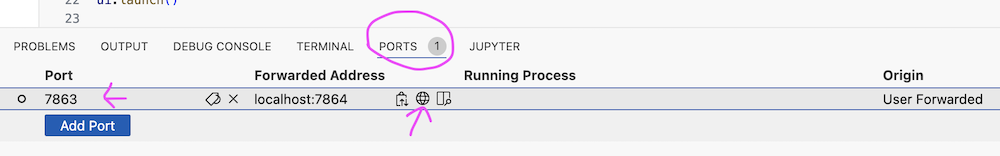
*For those who prefer a command-line option:*
1. Open a new terminal or command prompt window on your local computer.
2. Enter the following command to forward the remote port to a local port:
`ssh -L local_port:127.0.0.1:remote_port -J username@ssh.ist.psu.edu username@i4-cs-gpu01.ist.psu.edu` 
For example, if Gradio is running on 7863 port, my command looks this: `ssh -L 7861:localhost:7861 -J skb5969@ssh.ist.psu.edu skb5969@i4-cs-gpu01.ist.psu.edu`
3. Open your browser, create a new tab, and enter http://127.0.0.1:port (in this case, http://127.0.0.1:7861). You will see the interface.

In [7]:
# Custom CSS for full height
custom_css = """
#chatbot-container {
    height: calc(100vh - 230px) !important;
    overflow-y: auto;
}
#input-container {
    position: fixed;
    bottom: 0;
    left: 0;
    right: 0;
    padding: 20px;
    background-color: white;
    border-top: 1px solid #ccc;
}
"""

# Create the Gradio interface
with gr.Blocks(css=custom_css) as gr_iface:
    with gr.Column():
        chatbot = gr.Chatbot(elem_id="chatbot-container")
        with gr.Row(elem_id="input-container"):
            msg = gr.Textbox(
                show_label=False,
                placeholder="Type your message here... (Start with 'scrape:' to add a Wikipedia URL)",
                container=False
            )
            send = gr.Button("Send")
        clear = gr.Button("Clear")

    def user(user_message, history):
        return "", history + [[user_message, None]]

    def bot(history):
        user_message = history[-1][0]
        bot_message = chat(user_message, history[:-1])
        history[-1][1] = bot_message
        return history

    msg.submit(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, chatbot
    )
    send.click(user, [msg, chatbot], [msg, chatbot], queue=False).then(
        bot, chatbot, chatbot
    )
    clear.click(lambda: None, None, chatbot, queue=False)

# Launch the Gradio interface
gr_iface.launch()

INFO:httpx:HTTP Request: GET https://checkip.amazonaws.com/ "HTTP/1.1 200 "
INFO:httpx:HTTP Request: GET https://api.gradio.app/pkg-version "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: GET http://127.0.0.1:7861/startup-events "HTTP/1.1 200 OK"


Running on local URL:  http://127.0.0.1:7861


INFO:httpx:HTTP Request: HEAD http://127.0.0.1:7861/ "HTTP/1.1 200 OK"



To create a public link, set `share=True` in `launch()`.


INFO:__main__:Scraped content (first 1000 chars): Gradient descent

Gradient descent is a method for unconstrained mathematical optimization. It is a first-order iterative algorithm for minimizing a differentiable multivariate function.
The idea is to take repeated steps in the opposite direction of the gradient (or approximate gradient) of the function at the current point, because this is the direction of steepest descent. Conversely, stepping in the direction of the gradient will lead to a trajectory that maximizes that function; the procedure is then known as gradient ascent.
It is particularly useful in machine learning for minimizing the cost or loss function.[1] Gradient descent should not be confused with local search algorithms, although both are iterative methods for optimization.
Gradient descent is generally attributed to Augustin-Louis Cauchy, who first suggested it in 1847.[2] Jacques Hadamard independently proposed a similar method in 1907.[3][4] Its convergence properti

## 🚀 Conclusion

Congratulations! You've just created an advanced chatbot using LLMs, LangChain, and Gradio. Here's what we've covered:

1. We set up a custom LLM that interacts with an API.
2. We created a conversation chain with memory to maintain context.
3. We implemented Wikipedia scraping and information extraction.
4. We used FAISS for efficient vector storage and retrieval.
5. We built a user-friendly interface using Gradio.

This chatbot can now scrape Wikipedia articles, store the information in a vector database, and answer questions based on the scraped content. It also maintains a conversation memory for more contextual responses.

Remember, this is just the beginning! You can further enhance this chatbot by adding more features, improving the information extraction process, or integrating it with other knowledge sources.

Happy coding! 🚀🚀